# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Enter The Frontier!

And now - we put Frontier Models to the test.

### 2 important points:

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

In [1]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [2]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from testing import Tester

In [22]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['CLAUDE_API_KEY'] = os.getenv('CLAUDE_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
openai = OpenAI()
claude = Anthropic()

In [6]:
%matplotlib inline

In [7]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

# Before we look at the Frontier

## There is one more model we could consider

In [8]:
# Write the test set to a CSV

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [9]:
# Read it back in

human_predictions = []
with open('human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [10]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

In [11]:
# Tester.test(human_pricer, test)

## First, the humble but mighty GPT-4o-mini

It's called mini, but it packs a punch.

In [12]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [13]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nHabisder 2022 Laptops 14.1'' Laptop Computer, 8GB RAM 128GB SSD, Windows 10 Laptop, Celeron J3455 Processor, IPS Display, Ultra Slim Notebook PC, WiFi,\nColor Silver SSD Material plastic paint Screen type 14.1 inch IPS screen Screen resolution 1366 * 768 IPS CPU quad-core Graphics card HD set display CPU frequency quad-core 1.5GHz up to 2.3Ghz Operating system for Windows 10 64-bit Memory LPDDR3 8GB Hard disk 128GB SSD Can be expanded to 1TB SSD Built in wireless LAN Wireless standard / b / g / n / ac) Built-in sound chip Built in speaker Built in microphone Graphics card integrated graphics Input device touchpad"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [14]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [15]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [16]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [17]:
test[0].price

138.0

1: Guess: $299.99 Truth: $138.00 Error: $161.99 SLE: 0.60 Item: Habisder 2022 Laptops 14.1'' Laptop Comp...
2: Guess: $199.99 Truth: $399.99 Error: $200.00 SLE: 0.48 Item: 10" 1080P Backup Camera Monitor & Built-...
3: Guess: $299.99 Truth: $149.99 Error: $150.00 SLE: 0.48 Item: Avolusion PRO-5X Series 12TB USB 3.0 Ext...
4: Guess: $47.99 Truth: $73.05 Error: $25.06 SLE: 0.17 Item: LG EBF61215202 Genuine OEM Lid Switch As...
5: Guess: $12.99 Truth: $68.97 Error: $55.98 SLE: 2.59 Item: LG EBF62174902 LG-EBF62174902 Switch,Rot...
6: Guess: $649.99 Truth: $839.00 Error: $189.01 SLE: 0.06 Item: CyberpowerPC Gamer Master Gaming PC, AMD...
7: Guess: $89.99 Truth: $80.99 Error: $9.00 SLE: 0.01 Item: Herdio 5.25 Inch Wall Mount Passive Spea...
8: Guess: $10.99 Truth: $18.98 Error: $7.99 SLE: 0.26 Item: FitTurn Compatible with SKG V7 V7 Pro Ba...
9: Guess: $24.99 Truth: $23.99 Error: $1.00 SLE: 0.00 Item: TRUMiRR Watch Band for Fenix 7 Sapphire ...
10: Guess: $89.99 Truth: $78.99 Error: $11.00 

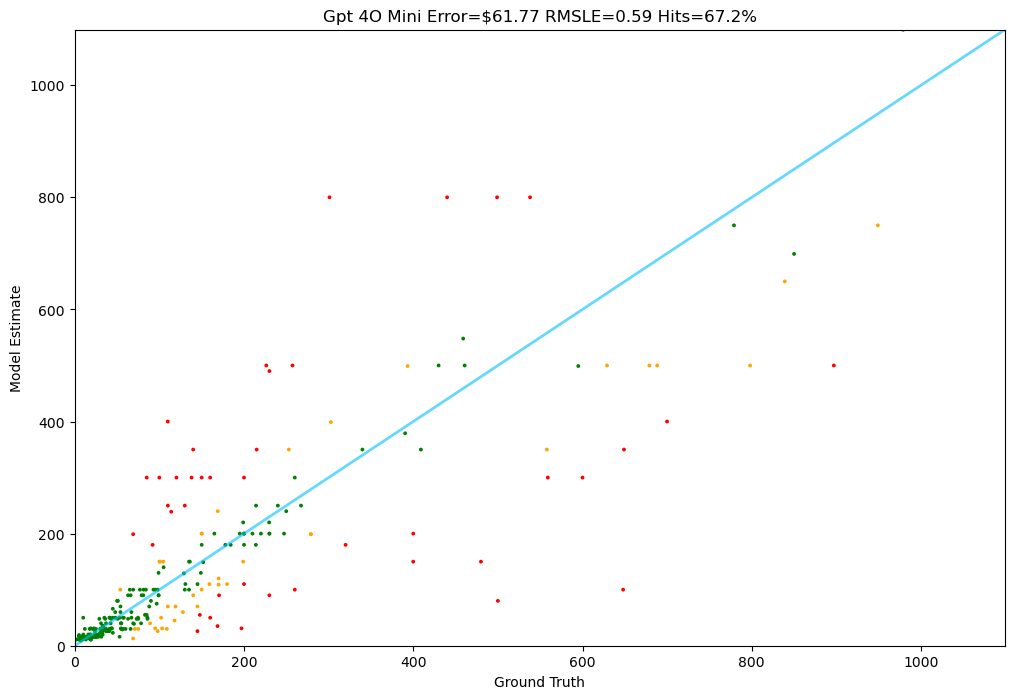

In [18]:
Tester.test(gpt_4o_mini, test)

In [19]:
# def gpt_4o_frontier(item):
#     response = openai.chat.completions.create(
#         model="gpt-4o-2024-08-06", 
#         messages=messages_for(item),
#         seed=42,
#         max_tokens=5
#     )
#     reply = response.choices[0].message.content
#     return get_price(reply)

In [ ]:
# The function for gpt-4o - the August model
# Note that it cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

# Tester.test(gpt_4o_frontier, test)

In [23]:
def claude_3_point_5_haiku(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-haiku-20241022",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

In [24]:
# The function for Claude 3.5 Haiku
# You can skip this and look at my results instead

Tester.test(claude_3_point_5_haiku, test)

AuthenticationError: Error code: 401 - {'type': 'error', 'error': {'type': 'authentication_error', 'message': 'invalid x-api-key'}}